In [1]:
import numpy as np
import pandas as pd
import gc
from nltk import FreqDist
import time
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, TimeDistributed, Dense, RepeatVector, Embedding, Bidirectional
from keras.optimizers import RMSprop
from keras.layers.recurrent import LSTM
from utils import *

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
input_vocab_size = 250
target_vocab_size = 346    # 1000 in full dataset
# target_vocab_size = 1000
num_samples = 500000
context_size = 3
padding_entity = [0]
self_sil_retention_percent = 0.5
X_seq_len = 60
y_seq_len = 20
hidden = 256
layers = 2
epochs = 5    # used just 1 for full dataset
batch_size = 128
val_split = 0.1
learning_rate = 0.1

## LSTM encoder/decoder for text normalization

Given a large corpus of written text aligned to its normalized spoken form, I will train an RNN to learn the correct normalization function. My model is a encoder-decoder with layers of bidirectional LSTMs.

Here is a quick summary of my model approach and architecture:

+ Character level input sequence, and word level output sequence
+ Input character vocabulary of 250 distinct characters. Output word vocabulary of 346 (the number of unique) distinct words.
+ Add a context window of 3 words to the left and right with a distinctive tag to separately identity the key token. I do this to manage the input sequence length reasonably.
+ Input sequence zero padding to a maximum of length 60. Output sequence padding to a maximum of length 20. I do this to create fixed-length sequences.
+ Model architecture with two components: an encoder and a decoder.
  - 256 hidden units in each layer of the encoder and decoder
  - Three bidirectional LSTM layers in the encoder
  - Two LSTM layers in the decoder

### 1. Create the encoder/decoder model

In [3]:
# let's make the model
model = Sequential()

# creating encoder network
model.add(Embedding(input_vocab_size+2, hidden, input_length=X_seq_len, mask_zero=True))
print('Embedding layer created')
model.add(Bidirectional(LSTM(hidden, return_sequences = True), merge_mode = 'concat'))
model.add(Bidirectional(LSTM(hidden, return_sequences = True), merge_mode = 'concat'))
model.add(Bidirectional(LSTM(hidden), merge_mode = 'concat'))
model.add(RepeatVector(y_seq_len))
print('Encoder layer created')

# creating decoder network
for _ in range(layers):
    model.add(LSTM(hidden, return_sequences=True))
model.add(TimeDistributed(Dense(target_vocab_size+1)))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
print('Decoder layer created')

# checking the model summary
model.summary()

Embedding layer created
Encoder layer created
Decoder layer created
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 60, 256)           64512     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 60, 512)           1050624   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 60, 512)           1574912   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 512)               1574912   
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 20, 512)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 20, 256)           787456    
_________________________________________________________________
lstm_5 (

### 2. Load the training data and do a quick exploratory analysis

In [4]:
start = time.time()

# load training data
X_train_data = pd.read_csv("en_train.csv")
X_train_data['before'] = X_train_data['before'].apply(str)
X_train_data['after'] = X_train_data['after'].apply(str)

print('Training data loaded in {0} s.'.format(time.time()-start))

print(X_train_data.shape)
X_train_data = X_train_data.iloc[:num_samples]
print(X_train_data.shape)
X_train_data.head()

Training data loaded in 10.547534227371216 s.
(9918441, 5)
(500000, 5)


,sentence_id,token_id,class,before,after
0,0,0,PLAIN,Brillantaisia,Brillantaisia
1,0,1,PLAIN,is,is
2,0,2,PLAIN,a,a
3,0,3,PLAIN,genus,genus
4,0,4,PLAIN,of,of


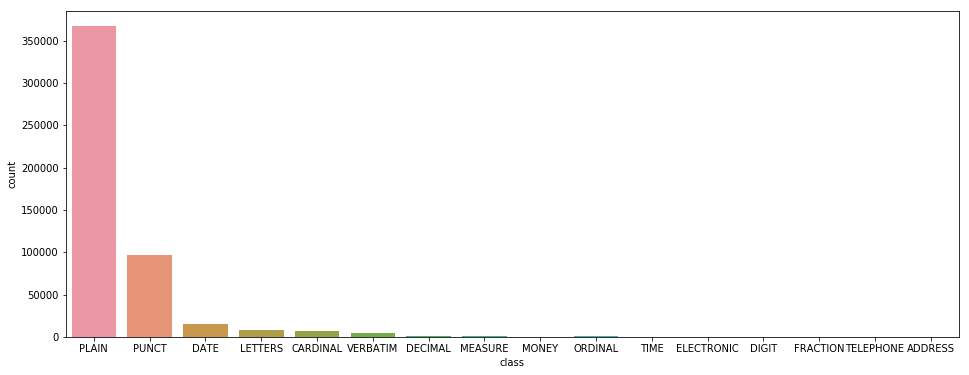

In [15]:
import seaborn as sns

# let's see how many training tokens fall into each class by
# plotting a count graph for the "Class" column of the data
fig = plt.figure(figsize=(16,6))
sns.countplot(x='class',data = X_train_data)

In [16]:
# the counts for number of sample tokens in each class group
X_train_data['class'].value_counts().sort_values(ascending = False)

PLAIN         367249
PUNCT          96157
DATE           15113
LETTERS         7631
CARDINAL        6850
VERBATIM        3916
MEASURE          782
ORDINAL          625
DECIMAL          516
MONEY            309
DIGIT            298
ELECTRONIC       217
TELEPHONE        189
TIME              61
FRACTION          56
ADDRESS           31
Name: class, dtype: int64

### 3. Create the input and target vocabularies

These are the vocabularies that the model can draw input from and decode output to.

In [5]:
start = time.time()

# create vocabularies
# target vocab
y = list(np.where(X_train_data['class'] == "PUNCT", "sil.",
      np.where(X_train_data['before'] == X_train_data['after'], "<self>",
               X_train_data['after'])))

y = [token.split() for token in y]
dist = FreqDist(np.hstack(y))
temp = dist.most_common(target_vocab_size-1)
temp = [word[0] for word in temp]
temp.insert(0, 'ZERO')
temp.append('UNK')

target_vocab = {word:ix for ix, word in enumerate(temp)}
print(len(target_vocab))
target_vocab_reversed = {ix:word for word,ix in target_vocab.items()}

# input vocab
X = list(X_train_data['before'])
X = [list(token) for token in X]

dist = FreqDist(np.hstack(X))
temp = dist.most_common(input_vocab_size-1)
temp = [char[0] for char in temp]
temp.insert(0, 'ZERO')
temp.append('<norm>')
temp.append('UNK')

input_vocab = {char:ix for ix, char in enumerate(temp)}

gc.collect()

print('Vocab created in {0} s.'.format(time.time()-start))

347
Vocab created in 7.653698921203613 s.


In [6]:
start = time.time()

# Converting input and target tokens to index values
X = index(X, input_vocab)
y = index(y, target_vocab)

gc.collect()

print('Replaced tokens with integers in {0} s.'.format(time.time()-start))

Replaced tokens with integers in 1.0112733840942383 s.


### 4. Data preprocessing

Add the context window (3 tokens previous and 3 tokens in the future) for each token of the training data. Pad these sequences to make each input sequence have a fixed length, and convert to an

In [7]:
start = time.time()

# adding a context window of 3 words in input, with token separated by <norm>
X = add_context_window(X, context_size, padding_entity, input_vocab)

print('Added context window to X in {0} s.'.format(time.time()-start))

Added context window to X in 2.1028590202331543 s.


In [8]:
start = time.time()

# padding
X = padding_batchwise(X, X_seq_len)
y = padding_batchwise(y, y_seq_len)

# convert to integer array, batch-wise (converting full data to array at once takes a lot of time)
X = np.array(X)
y = np.array(y)
y_sequences = np.asarray(sequences(y, y_seq_len, target_vocab))

print('Added padding and converted to np array in {0} s.'.format(time.time()-start))

Added padding and converted to np array in 36.42306995391846 s.


### 5. Training the LSTM encoder/decoder

I'll train 500,000 sample tokens for 5 epochs, with both model checkpointing (saving the model) after each epoch and early stop checking (stop training early if the validation accuracy gets worse- this means the model overfit!).

In [12]:
start = time.time()
from keras.callbacks import ModelCheckpoint, EarlyStopping

# fitting the model on the validation data with batch size set to 128 for a total of 5 epochs:
print('Fitting model...')
checkpointer = ModelCheckpoint(filepath='saved_model.hdf5', verbose=1, save_best_only=True)
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=1, mode='auto')
callbacks_list = [checkpointer, earlystop]

history = model.fit(X, y_sequences, batch_size=batch_size, epochs=epochs, validation_split=val_split, callbacks=callbacks_list, verbose=1)

Fitting model...
Train on 450000 samples, validate on 50000 samples
Epoch 1/5
450000/450000 [==============================] - 10409s 23ms/step - loss: 0.1299 - acc: 0.9722 - val_loss: 0.0472 - val_acc: 0.9899

Epoch 00001: val_loss improved from inf to 0.04722, saving model to saved_model.hdf5
Epoch 2/5
450000/450000 [==============================] - 16693s 37ms/step - loss: 0.0374 - acc: 0.9914 - val_loss: 0.0321 - val_acc: 0.9924

Epoch 00002: val_loss improved from 0.04722 to 0.03211, saving model to saved_model.hdf5
Epoch 3/5
450000/450000 [==============================] - 11865s 26ms/step - loss: 0.0281 - acc: 0.9931 - val_loss: 0.0259 - val_acc: 0.9934

Epoch 00003: val_loss improved from 0.03211 to 0.02590, saving model to saved_model.hdf5
Epoch 4/5
450000/450000 [==============================] - 10653s 24ms/step - loss: 0.0236 - acc: 0.9941 - val_loss: 0.0220 - val_acc: 0.9943

Epoch 00004: val_loss improved from 0.02590 to 0.02203, saving model to saved_model.hdf5
Epoch 5/

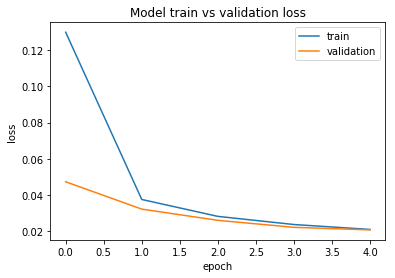

In [14]:
from matplotlib import pyplot as plt 

# let's double check that the model didn't overfit by comparing the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

### 6a. Predicting text normalization for test data

I'll use my trained model to predict normalization for the full (10,000 samples) test set.

In [46]:
# load weights from training
model.load_weights('saved_model.hdf5')

In [54]:
# prepare test data in the right format
X_test_data = pd.read_csv("en_test.csv")
X_test_data['before'] = X_test_data['before'].apply(str)
print(X_test_data.shape)
X_test_data = X_test_data[:100000]
print(X_test_data.shape)
X_test_data.head(10)

(1088564, 3)
(100000, 3)


,sentence_id,token_id,before
0,0,0,Another
1,0,1,religious
2,0,2,family
3,0,3,is
4,0,4,of
5,0,5,Hazrat
6,0,6,Sayyed
7,0,7,Ahmad
8,0,8,and
9,0,9,his


In [55]:
X_test = list(X_test_data['before'])
X_test = [list(token) for token in X_test]

X_test = index(X_test, input_vocab) # Convert to integer index
X_test = add_context_window(X_test, context_size, padding_entity, input_vocab) # Add context window
X_test = batch_wise_padding(X_test, X_seq_len) # Padding

# convert X_test to integer array, batch-wise (converting full data to array at once takes a lot of time)
# X_test = array_batchwise(X_test, X_seq_len)

In [56]:
# make predictions
test_predictions = np.argmax(model.predict(np.asarray(X_test), batch_size = 64, verbose=1), axis=2)

predicted_test_sequences = []
for prediction in test_predictions:
    sequence = ' '.join([target_vocab_reversed[index] for index in prediction if index > 0])
    predicted_test_sequences.append(sequence)
np.savetxt('test_result', predicted_test_sequences, fmt='%s')

100000/100000 [==============================] - 709s 7ms/step


### 6b. Investigating the model's predictions: what went wrong?

I'll focus on the "interesting" cases - where the model didn't predict <self\> or sil. These cass include dates, measures, money, and other cases that are not already trivially normalized. Per the concern I bring up in my write-up analysis that my model is only memorizing normalizations, I will also look at novel test cases that don't appear in my training data.

In [57]:
pred = pd.Series(predicted_test_sequences)
X_test_data['after'] = pred.values

X_test_data.head(10)

,sentence_id,token_id,before,after
0,0,0,Another,<self>
1,0,1,religious,<self>
2,0,2,family,<self>
3,0,3,is,<self>
4,0,4,of,<self>
5,0,5,Hazrat,<self>
6,0,6,Sayyed,<self>
7,0,7,Ahmad,<self>
8,0,8,and,<self>
9,0,9,his,<self>


In [58]:
# boring_cases = ['<self>', 'sil.']
# let's look at the interesting cases in the predicted for test data
interesting_cases = X_test_data[X_test_data['after'] != '<self>']
interesting_cases = interesting_cases[interesting_cases['after'] != 'sil.']
interesting_cases.head(30)

,sentence_id,token_id,before,after
30,2,4,75,seventy five
35,2,9,76,seventy six
40,2,14,124,one hundred twenty four
43,2,17,pp,p p
46,3,1,2010,twenty ten
52,3,7,25 m,seventy meters
56,3,11,200,two hundred
65,4,1,2,two
81,5,5,"3,400",thousand thousand five hundred
85,5,9,"10,200 ft",hundred hundred million dollars


In [59]:
# now let's look at the novel test cases- those that didn't appear in the training data
common = X_train_data.merge(X_test_data,on=['before'])
print(common.shape)
novel_cases = X_test_data[(~X_test_data.before.isin(common.before))]
print(novel_cases.shape)
novel_cases.head(30)

(591087539, 8)
(9863, 4)


,sentence_id,token_id,before,after
13,0,13,Haq,<self>
17,1,2,webapp,<self>
18,1,3,functionality,<self>
26,2,0,Kuklick,<self>
31,2,5,Kuklick,<self>
36,2,10,Westcott,<self>
41,2,15,Kuklick,<self>
47,3,2,FINA,<self>
52,3,7,25 m,seventy meters
70,4,6,Dn,<self>


In [60]:
# and now novel interesting cases
novel_interesting_cases = novel_cases[novel_cases['after'] != '<self>']
novel_interesting_cases = novel_interesting_cases[novel_interesting_cases['after'] != 'sil.']
novel_interesting_cases.head(30)

,sentence_id,token_id,before,after
52,3,7,25 m,seventy meters
81,5,5,"3,400",thousand thousand five hundred
85,5,9,"10,200 ft",hundred hundred million dollars
113,7,0,Pgs,p g
213,13,9,VPNs,d d <self>
255,16,17,3.9 kg,hundred point five meters
291,20,10,"13,004",thousand two thousand three
294,20,13,52.63 km2,point point per square kilometers
356,25,12,31 km,seventy meters
418,30,0,CUPS,s s u
